Shape  : (100000, 21)
Preview:
   USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  INTUBED  PNEUMONIA  \
0      2            12    1             1  9999-99-99       97          2   
1      2            12    2             1  9999-99-99       97          2   
2      2             4    2             1  9999-99-99       97          2   
3      2             9    1             1  9999-99-99       97          2   
4      1            12    2             1  9999-99-99       97          2   

   AGE  PREGNANT  DIABETES  ...  ASTHMA  INMSUPR  HYPERTENSION  OTHER_DISEASE  \
0   41         2         2  ...       2        2             2              2   
1   57         2         1  ...       2        2             2              2   
2   38         2         2  ...       2        2             2              2   
3   68         2         2  ...       2        2             2              2   
4   63         2         2  ...       2        2             1              2   

   CARDIOVASCULAR  

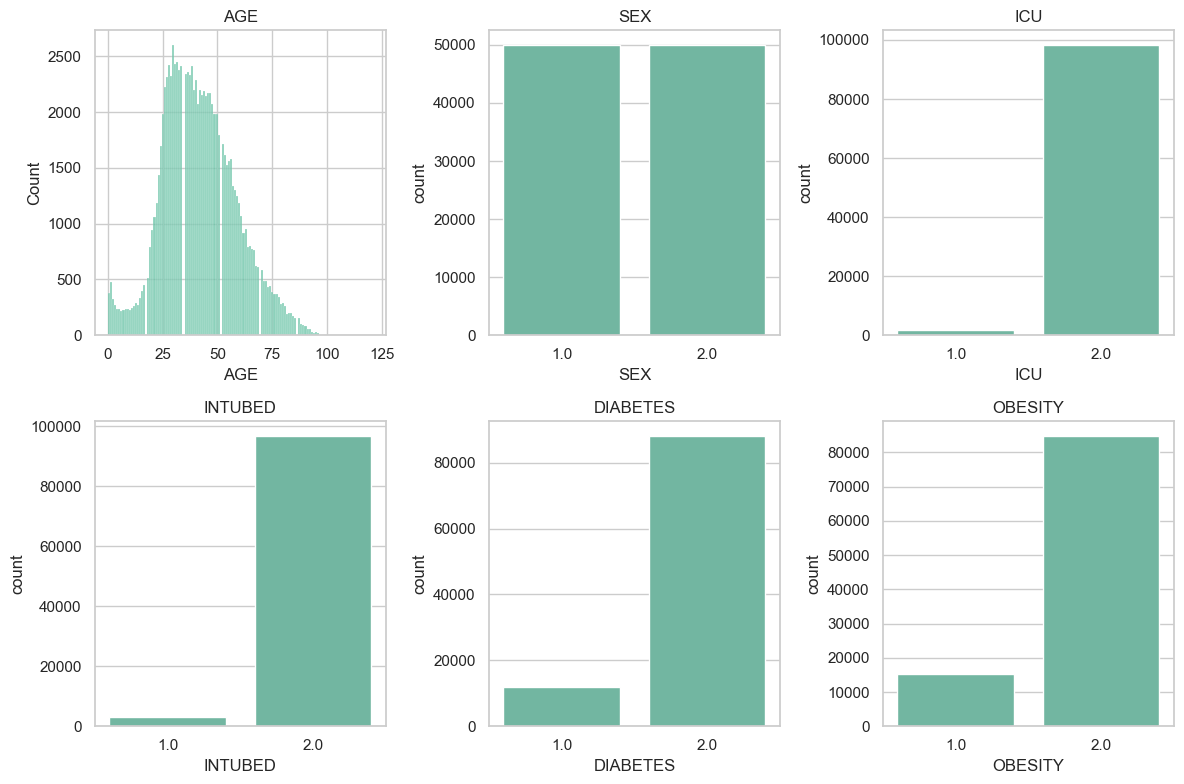

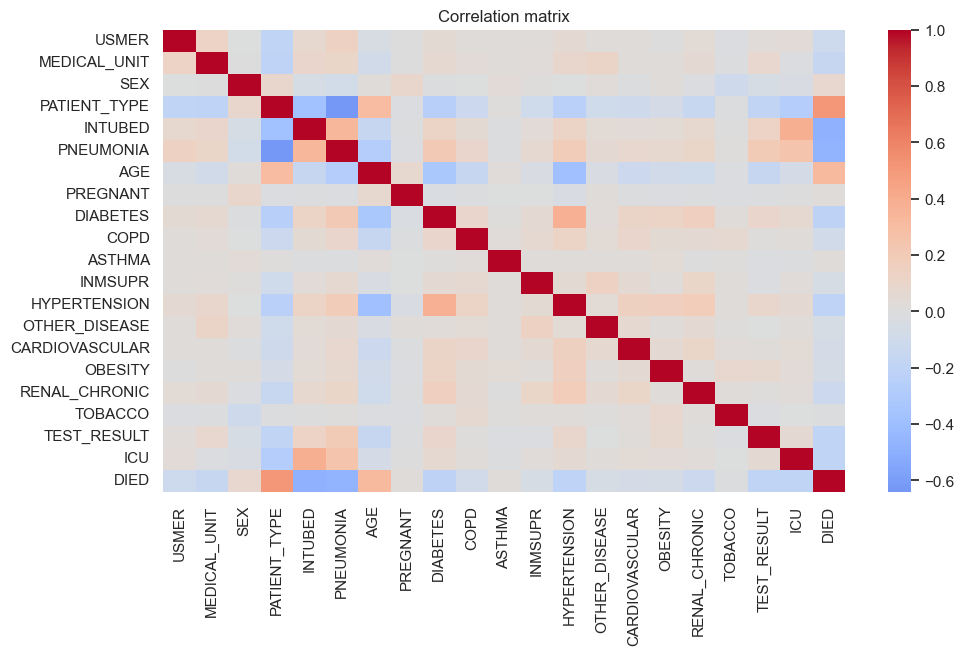


Top corr with DIED:
DIED            1.000000
PATIENT_TYPE    0.512000
INTUBED         0.491702
PNEUMONIA       0.468415
AGE             0.320164
DIABETES        0.214799
HYPERTENSION    0.205626
TEST_RESULT     0.201110
Name: DIED, dtype: float64

[Draft] O1 features: ['AGE', 'INTUBED', 'ICU', 'PNEUMONIA', 'DIABETES', 'COPD', 'HYPERTENSION', 'OBESITY', 'RENAL_CHRONIC', 'CARDIOVASCULAR']

✔ Cleaned dataset saved (custom_covid19_cleaned.csv)


In [2]:
##################################################################
# Step 1 – Exploratory Data Analysis (EDA)
# Engenharia do Conhecimento – 2024/25
##################################################################

############################
# 1.0 Imports & Settings
############################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
sns.set_theme(style="whitegrid", palette="Set2")   # 统一配色

############################
# 1.1 Load raw data
############################
df = pd.read_csv("./data/custom_covid19.csv")
print(f"Shape  : {df.shape}")
print(f"Preview:\n{df.head()}")

############################
# 1.2 Quick integrity check
############################
print("Duplicated rows:", df.duplicated().sum())
na_ratio = (df.isna().mean()*100).round(2)
print("\n% NaNs (raw):\n", na_ratio[na_ratio>0].sort_values(ascending=False))

############################
# 1.3 Variable typing & target engineering
############################
df["DIED"] = (df["DATE_DIED"] != "9999-99-99").astype(int)
num_cols = df.select_dtypes("number").columns.tolist()
cat_cols = df.columns.difference(num_cols + ["DATE_DIED", "DIED"])
print(f"→ numerical:{len(num_cols)}  categorical:{len(cat_cols)}")

############################
# 1.4 Missing-value handling
############################
# 替换 97/98/99 为 NaN，再用 mode / median 填补
df.replace([97, 98, 99], np.nan, inplace=True)
if len(cat_cols) > 0:
    df[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(df[cat_cols])
df[num_cols] = SimpleImputer(strategy="median").fit_transform(df[num_cols])

# --- optional ---  可视化 NA 分布
# sns.heatmap(df.isna(), cbar=False); plt.title("NA map"); plt.show()

############################
# 1.5 Descriptive statistics
############################
print(df[num_cols].describe().T.round(2))

############################
# 1.6 Outlier check (AGE only)
############################
q1, q3 = df["AGE"].quantile([.25, .75])
iqr = q3 - q1
low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
print(f"AGE outliers: {(df['AGE']<low).sum() + (df['AGE']>high).sum()}")
# --- optional ---
# sns.boxplot(x=df["AGE"]); plt.title("AGE – boxplot"); plt.show()

############################
# 1.7 Univariate distributions (quick grid)
############################
plot_cols = ["AGE", "SEX", "ICU", "INTUBED", "DIABETES", "OBESITY"]
n = len(plot_cols)
fig, axes = plt.subplots((n+2)//3, 3, figsize=(12, 8))
for ax, col in zip(axes.ravel(), plot_cols):
    if df[col].nunique() > 10:
        sns.histplot(df[col], kde=False, ax=ax)
    else:
        sns.countplot(x=col, data=df, ax=ax)
    ax.set_title(col)
plt.tight_layout(); plt.show()

############################
# 1.8 Correlations (numerical)
############################
corr = df[num_cols].corr(method="pearson")
plt.figure(figsize=(11,6))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation matrix"); plt.show()

# 简述强相关对
print("\nTop corr with DIED:")
print(corr["DIED"].abs().sort_values(ascending=False).head(8))

############################
# 1.9 Draft feature lists (manual + corr insight)
############################
important_features_O1 = ["AGE","INTUBED","ICU","PNEUMONIA",
                         "DIABETES","COPD","HYPERTENSION",
                         "OBESITY","RENAL_CHRONIC","CARDIOVASCULAR"]

important_features_O2 = ["DIABETES","COPD","TOBACCO","HYPERTENSION",
                         "CARDIOVASCULAR","RENAL_CHRONIC","OBESITY","ASTHMA","INMSUPR"]

important_features_O3 = ["ICU","INTUBED","PNEUMONIA","DIABETES",
                         "HYPERTENSION","OBESITY","RENAL_CHRONIC",
                         "COPD","TOBACCO","ASTHMA","INMSUPR"]

print("\n[Draft] O1 features:", important_features_O1)

############################
# 1.10 Save clean dataset
############################
df.to_csv("./data/custom_covid19_cleaned.csv", index=False)
print("\n✔ Cleaned dataset saved (custom_covid19_cleaned.csv)")


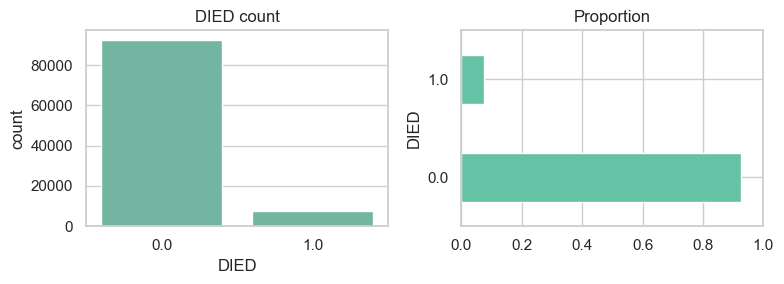

χ²=21935.95  p-value=0.0000


In [3]:
# %% [optional]   1️⃣ 目标分布 & 类不平衡
fig, ax = plt.subplots(1,2, figsize=(8,3))
sns.countplot(x="DIED", data=df, ax=ax[0]); ax[0].set_title("DIED count")
df["DIED"].value_counts(normalize=True).plot.barh(ax=ax[1])
ax[1].set_xlim(0,1); ax[1].set_title("Proportion")
plt.tight_layout(); plt.show()

# %% [optional]   2️⃣ 分类特征 Top-N 频次表
for col in cat_cols:
    print(f"\n{col} – top 5:")
    print(df[col].value_counts().head())

# %% [optional]   3️⃣ 交叉表 + χ² 检验（示例：PNEUMONIA vs DIED）
from scipy.stats import chi2_contingency
ct = pd.crosstab(df["PNEUMONIA"], df["DIED"])
chi2, p, _, _ = chi2_contingency(ct)
print(f"χ²={chi2:.2f}  p-value={p:.4f}")
